In [50]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt
import seaborn as sns

#from geopandas import GeoDataFrame
from shapely.geometry import Point,Polygon, LineString,shape

from shapely.strtree import STRtree
from shapely.ops import cascaded_union,unary_union

import os
from tqdm import tqdm # Para barra de progreso mas Cool


In [61]:
# User Functions
#==============================================================
def Get_Files(path):
    xfile = []
    try:
        for files in tqdm(os.listdir(path)):
            file = files.split('.')
            if file[1]=='shp':
                xfile.append(files)
    except:
        print('error en el archivo {}'.format(path))
    return xfile

# Cargar Datos extras de excel
#===============================================================
def get_extras(path, file):
    return pd.read_excel(path+file)

# Cargar Datos de los Yields
#===============================================================
def get_yield(path,file,var):
    yields = gpd.read_file(path+file)
    return yields[var].copy(),yields
    
# Agregar las variables ecxtras
#===============================================================
def get_vars(yields,extras,yield_):
    lote = yields.loc[1,'Lote'] # Filtra Lote
    date = yield_.loc[1,'Tiempo'] # Obtiene la fecha del archivo original
    date = date.split('-')[0]
    tipo = extras[extras['Lotes']==lote].copy()
    tipo['cam']= tipo['campaña'].apply(lambda x: x.split('-')[0]) # Agrego solo año inicial campaña
    tp = tipo[tipo['cam']==date].copy()
    
    # Agrego Variables Extras
    #==============================================================
    yields['Cultivo']=list(tp['cultivo'].values)[0]
    yields['Genotipo']=list(tp['genotipo'].values)[0]
    yields['campana']=list(tp['campaña'].values)[0]
    yields['fecha_s']=list(tp['fecha de siembra'].values)[0]
    
    return yields
    

    
    

# Carga de Datos

Cargaremos los datos de la cosecha de Maíz de la campaña 2015.

In [9]:
path = '../Data/yield_BL1/'
pathE = '../Data/Extras/'
maiz_2015 = gpd.read_file(path+'yield_mz_2015.shp')
maiz_2015.tail()

,Lote,Conjunto_d,Producto,Id_obj_,Tiempo,Duración_s,Cuenta_de_,Elevación_,Anch__de_f,Desviación,...,Humedad___,Num__de_pa,Flj_cultiv,Masa_de_re,_seco_Masa,_húmedo_Vo,Vol__de_re,Prod__ha_h,Fecha,geometry
182441,BL1,C1:3/22/2015 (Climate FieldView),Corn,16753.0,2015-03-22,1.0,Activado,93.7,7.28,0.0,...,10.6,30.0,0.0169,13.0646,13.0646,18124.5641,18124.5641,3.3647,2015-03-22,POINT (-61.57435 -34.38560)
182442,BL1,C1:3/22/2015 (Climate FieldView),Corn,16754.0,2015-03-22,1.0,Activado,93.6,7.28,0.0,...,10.6,30.0,0.0177,13.2392,13.2392,18366.7238,18366.7238,3.4757,2015-03-22,POINT (-61.57434 -34.38561)
182443,BL1,C1:3/22/2015 (Climate FieldView),Corn,16755.0,2015-03-22,1.0,Activado,93.5,7.28,0.0,...,10.6,30.0,0.0203,15.0916,15.0916,20936.6330,20936.6330,3.4852,2015-03-22,POINT (-61.57433 -34.38562)
182444,BL1,C1:3/22/2015 (Climate FieldView),Corn,16756.0,2015-03-22,1.0,Activado,93.5,7.28,0.0,...,10.6,30.0,0.0191,14.9139,14.9139,20690.0029,20690.0029,3.3307,2015-03-22,POINT (-61.57432 -34.38563)
182445,BL1,C1:3/22/2015 (Climate FieldView),Corn,16757.0,2015-03-22,1.0,Activado,93.5,7.28,0.0,...,10.6,30.0,0.0131,9.7932,9.7932,13586.0552,13586.0552,3.4732,2015-03-22,POINT (-61.57432 -34.38564)


Datos de Genotipo, tipo de cosecha

In [11]:
extras = pd.read_excel(pathE+'bd_campaña_cultivo_genotipo_fs.xlsx')
extras.head()

,Lotes,campaña,cultivo,genotipo,fecha de siembra
0,BT2,2015-2016,sj,NaN,NaN
1,BT3,2015-2016,sj,NaN,NaN
2,BT4,2015-2016,sj,NaN,NaN
3,BT5,2015-2016,sj,NaN,NaN
4,BT6,2015-2016,sj,NaN,NaN


### Información de las variables

In [3]:
maiz_2015.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 182446 entries, 0 to 182445
Data columns (total 24 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   Lote        182446 non-null  object  
 1   Conjunto_d  182446 non-null  object  
 2   Producto    182446 non-null  object  
 3   Id_obj_     182446 non-null  float64 
 4   Tiempo      182446 non-null  object  
 5   Duración_s  182446 non-null  float64 
 6   Cuenta_de_  182446 non-null  object  
 7   Elevación_  182446 non-null  float64 
 8   Anch__de_f  182446 non-null  float64 
 9   Desviación  182446 non-null  float64 
 10  Velocidad_  182446 non-null  float64 
 11  Distancia_  182446 non-null  float64 
 12  Curso_deg_  182446 non-null  float64 
 13  Hrv_Mass_W  182446 non-null  float64 
 14  Humedad___  182446 non-null  float64 
 15  Num__de_pa  182446 non-null  float64 
 16  Flj_cultiv  182446 non-null  float64 
 17  Masa_de_re  182446 non-null  float64 
 18  _seco_Masa  1824

In [4]:
# Variables de interes del Yield
#=====================================================
var_y = ['Lote','_seco_Masa','geometry']
maiz = maiz_2015[var_y].copy()
maiz.tail()

,Lote,_seco_Masa,geometry
182441,BL1,13.0646,POINT (-61.57435 -34.38560)
182442,BL1,13.2392,POINT (-61.57434 -34.38561)
182443,BL1,15.0916,POINT (-61.57433 -34.38562)
182444,BL1,14.9139,POINT (-61.57432 -34.38563)
182445,BL1,9.7932,POINT (-61.57432 -34.38564)


<AxesSubplot:>

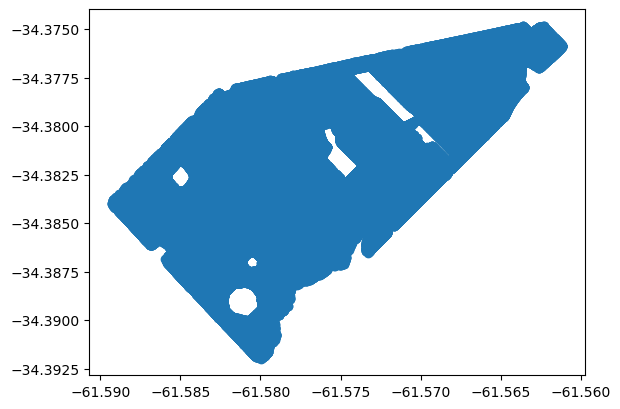

In [5]:
maiz.plot()

{'whiskers': [<matplotlib.lines.Line2D at 0x215979ff0d0>,
 'caps': [<matplotlib.lines.Line2D at 0x215979ff670>,
 'boxes': [<matplotlib.lines.Line2D at 0x215979d7dc0>],
 'medians': [<matplotlib.lines.Line2D at 0x215979ffc10>],
 'fliers': [<matplotlib.lines.Line2D at 0x215979ffee0>],
 'means': []}

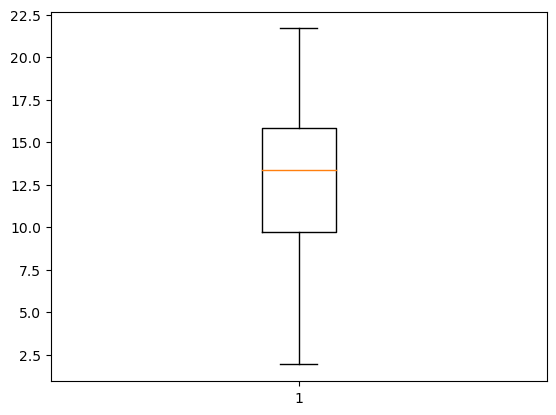

In [7]:
plt.boxplot(maiz['_seco_Masa'])

# Agregamos tipo cultivo y Genotipo

In [18]:
lote = maiz.loc[1,'Lote']
date = maiz_2015.loc[1,'Tiempo']
date = date.split('-')[0]
lote,date

('BL1', '2015')

In [21]:
tipo = extras[extras['Lotes']==lote].copy()
tipo['cam']= tipo['campaña'].apply(lambda x: x.split('-')[0])

In [28]:
tp = tipo[tipo['cam']==date].copy()
cultivo = list(tp['cultivo'].values)
geno = list(tp['genotipo'].values)
cultivo,geno

(['sj'], [nan])

In [38]:
maiz['Cultivo']=cultivo[0]
maiz['Genotipo']=geno[0]
maiz['campana']=list(tp['campaña'].values)[0]
maiz['fecha_s']=list(tp['fecha de siembra'].values)[0]

maiz.tail()

,Lote,_seco_Masa,geometry,Cultivo,Genotipo,campana,fecha_s
182441,BL1,13.0646,POINT (-61.57435 -34.38560),sj,NaN,2015-2016,NaN
182442,BL1,13.2392,POINT (-61.57434 -34.38561),sj,NaN,2015-2016,NaN
182443,BL1,15.0916,POINT (-61.57433 -34.38562),sj,NaN,2015-2016,NaN
182444,BL1,14.9139,POINT (-61.57432 -34.38563),sj,NaN,2015-2016,NaN
182445,BL1,9.7932,POINT (-61.57432 -34.38564),sj,NaN,2015-2016,NaN


In [52]:
# Buscar Archivos del Yield
#==================================================
files = Get_Files(path)


100%|██████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<?, ?it/s]


['yield_mz2_2018.shp',
 'yield_mz_2015.shp',
 'yield_mz_2017.shp',
 'yield_sy_2016.shp',
 'yield_sy_2019.shp',
 'yield_wh_2018.shp']

In [70]:
# Generar el dataframe con los yields
#==========================================================

# Load variables extras
#=============================================================
extras = get_extras(pathE, 'bd_campaña_cultivo_genotipo_fs.xlsx')

# Las variables de inters del Yiled
#===================================================================
var = ['Lote','_seco_Masa','geometry']

all_fields =  pd.DataFrame()

for file in tqdm(files):
    
    yields,yields_ = get_yield(path,file,var)
    temp = get_vars(yields,extras,yields_)
    
    all_fields = pd.concat([all_fields,temp],axis=0)
    
    
all_fields.reset_index(drop = True, inplace=True)
    

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:17<00:00, 12.85s/it]


In [74]:
all_fields.head()

,Lote,_seco_Masa,geometry,Cultivo,Genotipo,campana,fecha_s
0,BL1,1.1129,POINT (-61.58942 -34.38390),tr,Ceibo,2018-2019,2022-07-02
1,BL1,1.8112,POINT (-61.58941 -34.38390),tr,Ceibo,2018-2019,2022-07-02
2,BL1,2.0609,POINT (-61.58941 -34.38391),tr,Ceibo,2018-2019,2022-07-02
3,BL1,1.5176,POINT (-61.58940 -34.38392),tr,Ceibo,2018-2019,2022-07-02
4,BL1,1.1957,POINT (-61.58939 -34.38393),tr,Ceibo,2018-2019,2022-07-02


<AxesSubplot:>

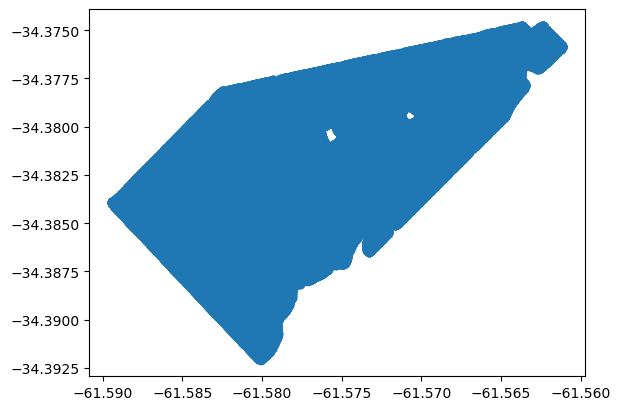

In [72]:
all_fields.plot()

In [73]:
all_fields['Lote'].unique()

array(['BL1'], dtype=object)